## Optimal Taxation Simulation - Constant Elasticity

---

Following BSS's approach

Outline:

* Have individuals optimize （quasi-linear + iso-elastic）
* Numerically integrate FOC 
* Interpolate tax schedule
* Numerically optimize for $z$ and check z(w) is non-decreasing (throw an error otherwise)
* Repeat

---

* Important to maintain the convexity of the tax schedule!
* Numerical integration issues

In [86]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from scipy import integrate
from scipy.interpolate import interp1d

In [87]:
# some global constants
bin_start = 0.01
nbins = 150
bin = 3.5
e = 0.5
gamma = 1
tol = 1e-6 # tolerance for termination

In [88]:
transfer = 0 # initially

### 1. Define the distribution and make a discretized version


We use a log normal distribution with $\mu = 2.757$ and $\sigma = 0.5611$ as MWY though we do not have an atom at $0.01$ for simplicity.

In [89]:
mu = 2.757
sigma = 0.5611
wages = [bin_start + bin * i for i in range(0, nbins)] # synnonymous with ability, for now
wages[-1] = 1e4 # try setting the top far
top = wages[-1]

In [90]:
normal = norm(loc=0, scale=1)
pmf = []

for wage in wages:
    bin_lower = max(0.01, wage - bin/2)
    bin_upper = wage + bin/2
    pmf.append(normal.cdf((np.log(bin_upper) - mu)/sigma) - normal.cdf((np.log(bin_lower) - mu)/sigma))

pmf = 1 / np.sum(pmf) * np.array(pmf)

### 2. Define agents

The utility function we use is:

$$U(c, l) = u(c) + v(l) = c - \frac{n}{1 + 1/e} \cdot \bigg(\frac{z}{n}\bigg)^{1 + 1/e}$$

s.t.

$$ c \leq w \cdot l - T(w \cdot l)$$

Note that $T(0) = -R$ is the transfer.

In [91]:
def get_poly_func(coefs):

    def poly_func(z):
        val = 0
        for (deg, coef) in enumerate(coefs):
                val += coef * z**deg
        return val

    return poly_func

In [92]:
class Agent:

    def __init__(self, wage):

        # note that this is a separating equilibrium, so higher ability workers always work more 
        # okay to assume the relative ordering stays the same over time

        self.wage = wage
        self.ls = 0.65**e # the guessed labor supply assuming a flat rate of 0.35
        self.util = None
        self.dudc = None # u'(c(theta))
        self.consumption = None
        self.taxpaid = None
        self.mrate = 0.35
    
    def max_util(self, transfer, tax_burden):
        '''
        utility maximization assuming Walrus's law holds (no extra budget)

        transfer: (float) from the government.
        tax_burden: (function) Takes in z and returns T(z) - T(0)
        '''
        
        # negative of the utility function since the routine minimizes instead of optimizes
        
        neg_utility_func = lambda l: -1 * (l * self.wage - tax_burden(l * self.wage) + transfer - self.wage / (1 + 1/e) * l**(1 + 1/e))
        non_neg_cons = lambda l: l # automatically interprets as l >= 0
        cons = {'type': 'ineq', 'fun': non_neg_cons}
        result = minimize(neg_utility_func, self.ls, constraints=cons)

        self.ls, self.util = result.x[0], result.fun * (-1) # new optimal labor supply
        self.taxpaid = tax_burden(self.wage*self.ls)
        self.consumption = self.wage*self.ls - self.taxpaid + transfer
        self.dudc = 1 # quasi-linear

        return self.ls*self.wage # pre-tax earnings this turn

Intialization for the search is important for the speed of convergence. We use the previous optimal labor supply as an educated guess for the starting point of the search under the new schedule.

### 3. Iterating to find the fixed point

#### 3.1 - Intialize a starting tax schedule $(T'(w) \equiv 0.35)$

In [93]:
# initially - initialize the economy - flat tax schedule
agents = []
tax_burden = get_poly_func([0, 0.35])

for wage in wages:
    agent = Agent(wage)
    optimal_wage = agent.max_util(transfer, tax_burden)
    agents.append(agent)

#### Update rule:

BSS's update rule, note the difference in SWF compared to MWY

$$\frac{T'(z)}{1 - T'(z)} = \frac{1}{e \cdot w \cdot f(w)} \cdot \int_w^{\infty} \bigg(1 - \frac{u(w)^{-\gamma}}{\lambda}\bigg)f(w)dw$$

$$\lambda = \int_0^{\infty} u(w)^{-\gamma}f(w) dw $$

* Need to interpolate $u(w)^{-\gamma}$

In [94]:
def density_ln(mean, std, x):

    '''
    Helper function that returns the log normal density with the specified parameters at x

    Inputs:
    mean: (float) mean of ln dist
    std: (float) standard deviation of ln dist
    x: (float) evaluation point

    Outputs:
    (float) density
    '''

    return 1/(x * std * np.sqrt(2 * np.pi)) * np.exp(-1 * (np.log(x) - mean)**2 / (2 * std**2))

In [95]:
def interp_util (wages, agents, gamma):

    x = np.array(wages)
    y = np.array([agent.util**(-1 * gamma) for agent in agents])

    # Create an interpolation function
    interp_func = interp1d(x, y, kind='linear')

    return interp_func

In [96]:
interp_gamma_util_func = interp_util(wages, agents, gamma)

C:\Users\Bryant Xia\AppData\Local\Temp\ipykernel_22636\3489975962.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  lambda_mult = integrate.quad(lambda_integrand, bin_start, top, limit=100)[0]


0 0.65 5.202714155243139
1 0.4502978289939858 0.04691173469156951
2 0.20074963953163505 0.9857198853223119


3 0.08125000000000004 0.11381726602704934
4 0.04062500000000002 0.0020592953392828406
5 0.020312499999999956 0.01812120212768953
6 0.010156249999999978 0.011088629481268875
7 0.005078125000000044 0.003928811832542678
8 0.002539062500000022 0.0015673883236111408
9 0.0012695312499999556 0.0008091457141334857
10 0.0006347656249999778 0.00032145833880736774
11 0.0003173828125000444 0.00014913663297910773
12 0.0001586914062500222 4.192700799521276e-05
13 7.934570312495559e-05 3.423081919962101e-05
14 3.9672851562477796e-05 1.6451012983864644e-05
15 1.983642578129441e-05 6.643684198337496e-06
16 9.918212890647204e-06 2.384105871833242e-06
17 4.959106445268091e-06 1.133518586549087e-06
18 2.4795532226340455e-06 4.0868125594784033e-07
19 1.239776611372534e-06 3.107144719294297e-07
20 0 9.339727480295323e-08


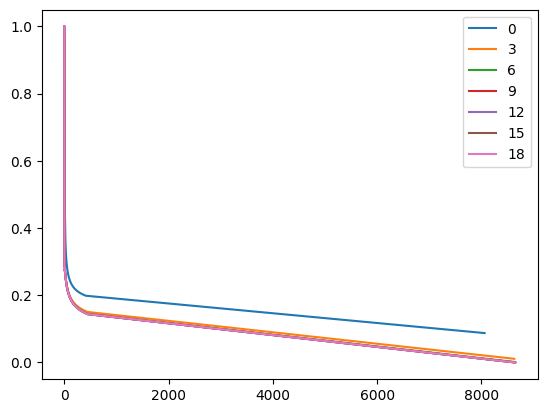

In [97]:
iterations = 0

while True:

    revenue_check = True # if the new tansfer is within 1e-6 of the prev
    derivative_check = True # if marginal taxes are not updated by more than 1e-6
    worst_diff = 0 # largest absolute difference in rate update

    # components of RHS

    interp_gamma_util_func = interp_util(wages, agents, gamma)
    lambda_integrand = lambda w: interp_gamma_util_func(w) * density_ln(mu, sigma, w)
    lambda_mult = integrate.quad(lambda_integrand, bin_start, top, limit=100)[0]

    prev_integral_val = 0
    new_rates = []
    new_zs = []

    revenue = np.dot(pmf, np.array([agent.taxpaid for agent in agents]))

    for (index, agent) in enumerate(reversed(agents)):

        rhs_integrand = lambda w: (1 - interp_gamma_util_func(w) / lambda_mult) * density_ln(mu, sigma, w)
        
        if index == 0:
            rhs_integral_val = integrate.quad(rhs_integrand, agent.wage, top, limit=100)[0]
        else:
            rhs_integral_val = integrate.quad(rhs_integrand, agent.wage, agents[len(agents) - index].wage, limit=100)[0] + prev_integral_val
        
        prev_integral_val = rhs_integral_val
        rhs = 1 / e * 1 / (agent.wage * density_ln(mu, sigma, agent.wage)) * rhs_integral_val
        new_rate = max(rhs/(1 + rhs), 0) # negative rates never optimal


        if abs(agent.mrate - new_rate) > tol:
            if abs(agent.mrate - new_rate) > worst_diff:
                worst_diff = abs(agent.mrate - new_rate)
            derivative_check = False

        agent.mrate = (agent.mrate + new_rate)/2
        new_rates.append((agent.mrate + new_rate)/2) # step size control
        new_zs.append(agent.ls * agent.wage)
    
    if iterations % 3 == 0:
        plt.plot(new_zs, new_rates, label = str(iterations))

    if abs(transfer - revenue) > tol:
        revenue_check = False

    print(iterations, worst_diff, abs(revenue - transfer))
     
    if revenue_check and derivative_check:
        break

    transfer = revenue

    coefs = np.polyfit(new_zs, new_rates, deg = 2) # the choice of degree matters a lot; somehow 2 works, 5 explodes, etc.
    tax_schedule = []
    for (deg, coef) in enumerate(coefs[1:]):
        tax_schedule.append(deg * coef)
    tax_burden = get_poly_func(tax_schedule)

    for agent in agents:
        optimal_wage = agent.max_util(transfer, tax_burden)

    iterations += 1

plt.legend()
plt.show()

### Visuals:

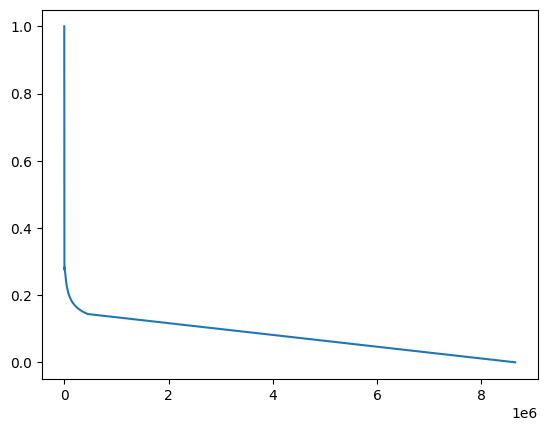

In [98]:
xs = []
ys = []

for agent in agents:
    xs.append(agent.wage * agent.ls * 1000)
    ys.append(agent.mrate)

plt.plot(xs, ys)

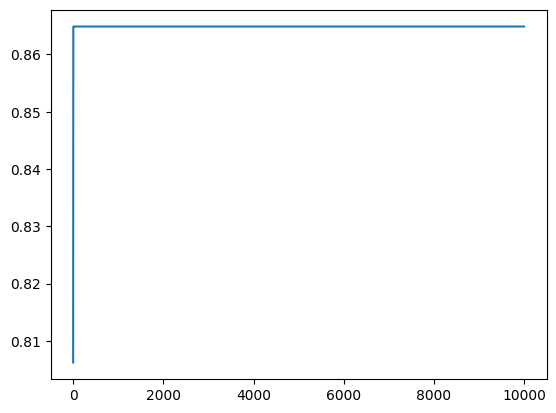

In [99]:
xs = []
ys = []

for agent in agents:
    xs.append(agent.wage)
    ys.append(agent.ls)

plt.plot(xs, ys)